In [1]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
import os
import torch
import torchvision.models
from torch import nn
from torch.utils.data import Dataset as TorchDataset, DataLoader
import torch.optim as TorchOptimizers
import torchvision.transforms.v2 as T
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import deeplabv3_resnet50
from torchinfo import summary as torch_summary
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import math
import time
import wandb
from sklearn.model_selection import train_test_split
import json
from typing import Callable

In [2]:
@dataclass
class Config:
    train_csv_filepath: str
    test_csv_filepath: str
    submission_filepath: str
    images_root_folder: str
    image_masks_root_folder: str
    training_output_folder: str
    saved_weights_filepath: str
    device: str

    def __post_init__(self):
        """ For configuration variables that are shared across environments """
        self.num_classes = 12
        self.batch_size = 32
        self.starting_learning_rate = 4e-4
        self.max_epochs = 100
        self.patience = 20
        self.seed = 1234
        self.num_workers = 4 if self.device == 'cuda' else 0
        self.pin_memory = self.num_workers > 0

    # noinspection PyAttributeOutsideInit
    def init(self, training):
        """ Adjust configuration setup for training vs inference """
        self.training = training

        if self.training:
            os.makedirs(self.training_output_folder, exist_ok=True)

        self.imagenet_mean_cpu_tensor = torch.tensor(imagenet_mean_array)
        self.imagenet_std_cpu_tensor = torch.tensor(imagenet_std_array)
        self.channelwise_imagenet_mean_cpu_tensor = self.imagenet_mean_cpu_tensor.view(3, 1, 1)
        self.channelwise_imagenet_std_cpu_tensor = self.imagenet_std_cpu_tensor.view(3, 1, 1)
        self.imagenet_mean_gpu_tensor = gpu_tensor(imagenet_mean_array)
        self.imagenet_std_gpu_tensor = gpu_tensor(imagenet_std_array)
        self.channelwise_imagenet_mean_gpu_tensor = self.imagenet_mean_gpu_tensor.view(3, 1, 1)
        self.channelwise_imagenet_std_gpu_tensor = self.imagenet_std_gpu_tensor.view(3, 1, 1)

        self.image_transforms = T.Compose([
            T.ToImage(),
            T.ToDtype(torch.float32, scale=True),
            T.Normalize(self.imagenet_mean_cpu_tensor, self.imagenet_std_cpu_tensor),
        ])

config: Config = None
""" Set to environment-relevant config before training/inference """;

In [3]:
local_config = Config(
    train_csv_filepath='data/train.csv',
    test_csv_filepath='data/test.csv',
    submission_filepath='data/submission.csv',
    images_root_folder='data/images/',
    image_masks_root_folder='data/masks/',
    training_output_folder='data_gen/training_output/',
    saved_weights_filepath='data_gen/training_output/model_weights.pth',
    device='cpu',
)
kaggle_config = Config(
    train_csv_filepath='/kaggle/input/opencv-pytorch-segmentation-project-round2/train.csv',
    test_csv_filepath='/kaggle/input/opencv-pytorch-segmentation-project-round2/test.csv',
    images_root_folder='/kaggle/input/opencv-pytorch-segmentation-project-round2/imgs/imgs/',
    image_masks_root_folder='/kaggle/input/opencv-pytorch-segmentation-project-round2/masks/masks/',
    submission_filepath='/kaggle/working/submission.csv',
    training_output_folder='/kaggle/working/training_output/',
    saved_weights_filepath='/kaggle/working/training_output/model_weights.pth',
    device='cuda',
)

In [4]:
imagenet_mean_array = np.array([0.485, 0.456, 0.406], dtype=np.float32)
imagenet_std_array = np.array([0.229, 0.224, 0.225], dtype=np.float32)

# 12 visually diverse colors for semantic segmentation classes
CLASS_COLORS = np.array([
    [0, 0, 0],        # 0: Black (background)
    [255, 0, 0],      # 1: Red
    [0, 255, 0],      # 2: Green
    [0, 0, 255],      # 3: Blue
    [255, 255, 0],    # 4: Yellow
    [255, 0, 255],    # 5: Magenta
    [0, 255, 255],    # 6: Cyan
    [255, 128, 0],    # 7: Orange
    [128, 0, 255],    # 8: Purple
    [0, 128, 255],    # 9: Light Blue
    [255, 128, 128],  # 10: Pink
    [128, 255, 128],  # 11: Light Green
], dtype=np.uint8)

def gpu_tensor(numpy_array):
    return torch.tensor(numpy_array, device=config.device)

def visualize_image(image_tensor):
    """ Input tensor should be on gpu """
    image = denormalize(image_tensor, config.channelwise_imagenet_mean_gpu_tensor, config.channelwise_imagenet_std_gpu_tensor)
    image = torch.clamp(image, 0, 1)
    image = image.permute(1, 2, 0).cpu().numpy()
    image = (image * 255).astype('uint8')
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    plt.close()

def visualize_mask(mask_tensor):
    """Input: (H, W) tensor with class indices 0-11"""
    mask = mask_tensor.cpu().numpy()
    mask = np.clip(mask, 0, config.num_classes - 1).astype(np.int32)
    colored_mask = CLASS_COLORS[mask]
    plt.imshow(colored_mask)
    plt.axis('off')
    plt.show()
    plt.close()

def normalize(tensor, mean, std):
    return (tensor - mean) / std

def denormalize(tensor, mean, std):
    return tensor * std + mean

def load_pil_image_from_id(image_id) -> ImageFile.ImageFile:
    return Image.open(config.images_root_folder + image_id + '.jpg')

In [5]:
@dataclass
class ImageSegmentationDataset(TorchDataset):
    image_ids: np.ndarray
    image_transforms: Callable

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image = Image.open(f'{config.images_root_folder}{image_id}.jpg')
        mask = Image.open(f'{config.image_masks_root_folder}{image_id}.png')

        transformed_image = self.image_transforms(image)
        # Convert mask to tensor directly - no normalization
        # Mask contains class indices 0-11, shape becomes (H, W)
        mask_array = np.array(mask)
        transformed_mask = torch.from_numpy(mask_array).long()

        return transformed_image, transformed_mask

In [6]:
# test_model = deeplabv3_resnet50(weights=DeepLabV3_ResNet50_Weights.DEFAULT)
# torch_summary(test_model)

In [7]:
# test_model

In [8]:
# aux_classifier_children = test_model.aux_classifier.children()
# for layer in aux_classifier_children:
#     print(layer)

In [9]:
def create_deeplab_v3_model() -> nn.Module:
    weights_backbone = ResNet50_Weights.DEFAULT if config.training else None
    model = deeplabv3_resnet50(
        weights=None,
        weights_backbone=weights_backbone,
        num_classes=config.num_classes,
        aux_loss=True,
    )

    for param in model.backbone.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    for param in model.aux_classifier.parameters():
        param.requires_grad = True

    model.to(config.device)

    return model

In [10]:
def dice_coefficient_batch(pred_logits, true_masks, num_classes):
    """Compute per-class intersection and union for a batch.
    
    Args:
        pred_logits: (B, C, H, W) raw model output logits
        true_masks: (B, H, W) ground truth class indices
        num_classes: number of classes
    
    Returns:
        intersection: (num_classes,) tensor
        union: (num_classes,) tensor
    """
    pred_classes = pred_logits.argmax(dim=1)  # (B, H, W)
    
    intersection = torch.zeros(num_classes, device=pred_logits.device)
    union = torch.zeros(num_classes, device=pred_logits.device)
    
    for c in range(num_classes):
        pred_c = (pred_classes == c)
        true_c = (true_masks == c)
        intersection[c] = (pred_c & true_c).sum()
        union[c] = pred_c.sum() + true_c.sum()
    
    return intersection, union

def compute_mean_dice(total_intersection, total_union):
    """Compute mean Dice score from accumulated intersection/union values."""
    valid = total_union > 0
    dice = torch.zeros_like(total_intersection)
    dice[valid] = (2 * total_intersection[valid]) / total_union[valid]
    return dice[valid].mean().item()

def train_one_epoch(start_time, model, loader, optimizer, loss_function):
    model.train()
    running_loss = 0.0
    
    # Running sums for incremental Dice computation
    total_intersection = torch.zeros(config.num_classes, device=config.device)
    total_union = torch.zeros(config.num_classes, device=config.device)

    num_batches = math.ceil(len(loader.dataset) / config.batch_size)
    for batch_number, (x, y) in enumerate(loader):
        print(f't={time.time() - start_time:.2f}: Loading training batch {batch_number + 1}/{num_batches}')

        x = x.to(config.device, non_blocking=True)
        y = y.to(config.device, non_blocking=True)

        if batch_number == 0:
            allocated = torch.cuda.memory_allocated(config.device) / 1024**3
            reserved = torch.cuda.memory_reserved(config.device) / 1024**3
            print(f'Memory allocated={allocated:.2f} GiB, reserved={reserved:.2f} GiB')
            print(f'First image:')
            visualize_image(x[0])
            print(f'First mask (unique values: {torch.unique(y[0]).tolist()}):')
            visualize_mask(y[0])

        optimizer.zero_grad()
        
        # Handle DeepLabV3 dictionary output
        output = model(x)
        preds = output['out'] if isinstance(output, dict) else output
        
        loss = loss_function(preds, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)

        # Compute batch Dice incrementally (no accumulation)
        with torch.no_grad():
            batch_inter, batch_union = dice_coefficient_batch(preds, y, config.num_classes)
            total_intersection += batch_inter
            total_union += batch_union
        
        # Clean up to free memory
        del output, preds, loss
        
    # Clear GPU cache at end of epoch
    if config.device == 'cuda':
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_score = compute_mean_dice(total_intersection, total_union)

    return epoch_loss, epoch_score

@torch.no_grad()
def validate_one_epoch(start_time, model, loader, loss_function):
    model.eval()
    running_loss = 0.0

    # Running sums for incremental Dice computation
    total_intersection = torch.zeros(config.num_classes, device=config.device)
    total_union = torch.zeros(config.num_classes, device=config.device)
    
    num_batches = math.ceil(len(loader.dataset) / config.batch_size)
    for batch_number, (x, y) in enumerate(loader):
        print(f't={time.time() - start_time:.2f}: Loading validation batch {batch_number + 1}/{num_batches}')

        x = x.to(config.device, non_blocking=True)
        y = y.to(config.device, non_blocking=True)

        if batch_number == 0:
            print('First image:')
            visualize_image(x[0])
            print(f'First mask (unique values: {torch.unique(y[0]).tolist()}):')
            visualize_mask(y[0])

        # Handle DeepLabV3 dictionary output
        output = model(x)
        preds = output['out'] if isinstance(output, dict) else output
        
        loss = loss_function(preds, y)

        running_loss += loss.item() * x.size(0)

        # Compute batch Dice incrementally (no accumulation)
        batch_inter, batch_union = dice_coefficient_batch(preds, y, config.num_classes)
        total_intersection += batch_inter
        total_union += batch_union
        
        # Clean up to free memory
        del output, preds, loss
    
    # Clear GPU cache at end of epoch
    if config.device == 'cuda':
        torch.cuda.empty_cache()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_score = compute_mean_dice(total_intersection, total_union)

    return epoch_loss, epoch_score

In [11]:
def train():
    config.init(training=True)

    start_time = time.time()
    print('t=0: Starting data prep and model loading')

    run = wandb.init(
        project='drone_image_segmentation',
        name=f'run={int(start_time)}',
        config={
            'batch_size': config.batch_size,
            'learning_rate': config.starting_learning_rate,
            'max_epochs': config.max_epochs,
            'seed': config.seed,
            'model': 'deeplabv3_resnet50',
            'optimizer': 'Adam',
        },
    )

    train_df = pd.read_csv(config.train_csv_filepath)
    train_array = train_df['ImageID'].to_numpy()
    train_ids, val_ids = train_test_split(train_array, test_size=0.2, random_state=config.seed)

    model = create_deeplab_v3_model()

    wandb.watch(model, log='gradients', log_freq=100)

    train_dataset = ImageSegmentationDataset(train_ids, config.image_transforms)
    val_dataset = ImageSegmentationDataset(val_ids, config.image_transforms)

    def loader(ds, shuffle):
        return DataLoader(ds, shuffle=shuffle, batch_size=config.batch_size, num_workers=config.num_workers, pin_memory=config.pin_memory)

    train_loader = loader(train_dataset, shuffle=True)
    val_loader = loader(val_dataset, shuffle=False)

    # Use CrossEntropyLoss for multi-class segmentation with class indices
    loss_function = nn.CrossEntropyLoss()
    optimizer = TorchOptimizers.Adam(model.parameters(), lr=config.starting_learning_rate)

    best_val_loss = float('inf')
    best_val_loss_epoch = -1
    best_val_score = float('-inf')
    best_val_score_epoch = -1

    history = dict(train_loss=[], val_loss=[], train_score=[], val_score=[], best_val_score_epoch=dict(), best_val_loss_epoch=dict())

    training_start_time = time.time()
    print(f't={training_start_time - start_time:.2f}: Starting training')
    torch.manual_seed(config.seed)

    # File paths for saving best models directly to disk
    best_score_weights_path = config.training_output_folder + 'best_model_weights.pth'
    best_loss_weights_path = config.training_output_folder + 'best_loss_model_weights.pth'
    
    epochs_since_best = 0

    for epoch in range(1, config.max_epochs + 1):
        epoch_start_time = time.time()
        print(f't={epoch_start_time - start_time:.2f}: Starting epoch {epoch}')
        train_loss, train_score = train_one_epoch(start_time, model, train_loader, optimizer, loss_function)
        val_loss, val_score = validate_one_epoch(start_time, model, val_loader, loss_function)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_score'].append(train_score)
        history['val_score'].append(val_score)

        print(f'================ Epoch {epoch:03d} stats ==================')
        print(f'train_loss: {train_loss:.4f}  val_loss: {val_loss:.4f}')
        print(f'train_score: {train_score:.4f}  val_score: {val_score:.4f}')
        print('===================================================')

        wandb.log(
            {
                'epoch': epoch,
                'train_loss': train_loss,
                'val_loss': val_loss,
                'train_score': train_score,
                'val_score': val_score,
            }
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_loss_epoch = epoch
            # Save directly to disk instead of cloning to memory
            torch.save(model.state_dict(), best_loss_weights_path)

        if val_score > best_val_score:
            best_val_score = val_score
            best_val_score_epoch = epoch
            epochs_since_best = 0
            # Save directly to disk instead of cloning to memory
            torch.save(model.state_dict(), best_score_weights_path)
        else:
            epochs_since_best += 1
            if epochs_since_best >= config.patience:
                break

    history['best_val_score_epoch']['epoch'] = best_val_score_epoch
    history['best_val_score_epoch']['val_score'] = best_val_score
    history['best_val_loss_epoch']['epoch'] = best_val_loss_epoch
    history['best_val_loss_epoch']['val_loss'] = best_val_loss

    print()
    print('==================== Results ======================')
    print(f'Best val score epoch: {best_val_score_epoch}')
    print(f'Best val score: {best_val_score:.4f}')
    print(f'Best val loss epoch: {best_val_loss_epoch}')
    print(f'Best val loss: {best_val_loss:.2f}')
    print('===================================================')
    print()

    wandb.run.summary['best_val_score'] = best_val_score
    wandb.run.summary['best_val_score_epoch'] = best_val_score_epoch
    wandb.run.summary['best_val_loss'] = best_val_loss
    wandb.run.summary['best_val_loss_epoch'] = best_val_loss_epoch

    train_score = history['train_score']
    val_score = history['val_score']
    epochs = list(range(1, len(train_score) + 1))

    plt.figure(figsize=(8, 5))

    plt.plot(epochs, train_score, label='train_score', marker='o')
    plt.plot(epochs, val_score, label='val_score', marker='o')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train vs Validation Score per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    wandb.log({"score_curve": wandb.Image(plt.gcf())})

    plt.show()
    plt.close()

    with open(config.training_output_folder + 'history.json', 'w') as json_file:
        json.dump(history, json_file, indent=4)

    wandb.save(best_score_weights_path)
    wandb.save(best_loss_weights_path)
    wandb.save(config.training_output_folder + 'history.json')

    wandb.finish()

In [12]:
# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# wandb_key = user_secrets.get_secret("wandb_key")
# !wandb login $wandb_key

t=0: Starting data prep and model loading


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


t=9.57: Starting training
t=9.57: Starting epoch 1
t=9.99: Loading training batch 1/66
Memory allocated=0.00 GiB, reserved=0.00 GiB
First image:


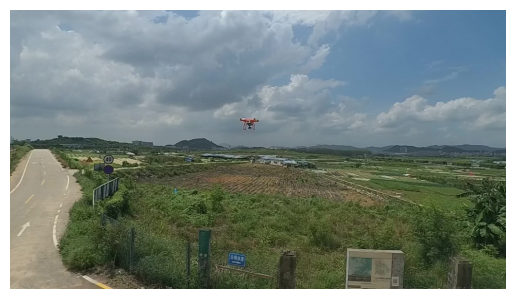

First mask (unique values: [0, 4, 7, 8, 9, 10, 11]):


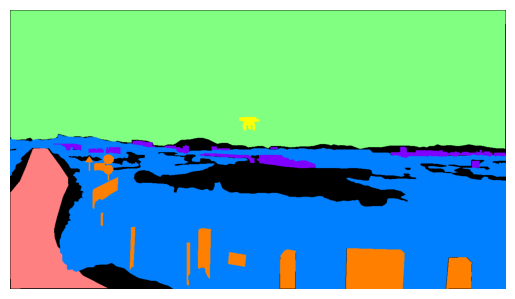

In [ ]:
wandb.finish()
config = local_config
train()